In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

satellites = {
  'MODIS': 1,
  'VIIRS': 2
}

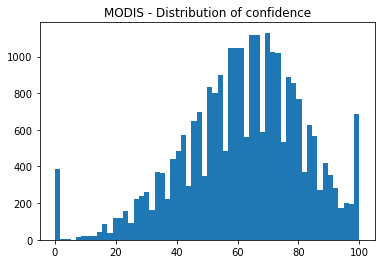

In [2]:
m1 = pd.read_csv('MODIS-2021.csv')
m1['type'] = m1['type'] + 2
m2 = pd.read_csv('MODIS-2022-arch.csv')
m2['type'] = m2['type'] + 2
m3 = pd.read_csv('MODIS-2022.csv')
m3['type'] = 1

modis = pd.concat([m1, m2, m3], ignore_index=True, names=False)
modis['satellite'] = satellites['MODIS']

plt.figure(facecolor='white')
plt.title("MODIS - Distribution of confidence")
plt.hist(modis['confidence'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [3]:
v1 = pd.read_csv('VIIRS-2022.csv')
v1['type'] = 1
v2 = pd.read_csv('VIIRS-NOAA-2022-arch.csv')
v2['type'] = v2['type'] + 2
v3 = pd.read_csv('VIIRS-NOAA-2022.csv')
v3['type'] = 1

viirs = pd.concat([v1, v2, v3], ignore_index=True, names=False)
viirs['satellite'] = satellites['VIIRS']

print("VIIRS - Low confidence %")
cutoff = np.count_nonzero(viirs['confidence'] == 'l') / len(viirs) * 100
cutoff

VIIRS - Low confidence %


6.396893177768065

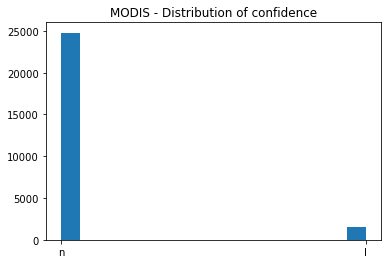

In [4]:
modis['confidence'] = np.where(modis['confidence'] < 30, 'l', 'n')

plt.figure(facecolor='white')
plt.title("MODIS - Distribution of confidence")
plt.hist(modis['confidence'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [5]:
firms = pd.concat([modis, viirs], ignore_index=True, names=False)
firms = firms.drop(columns=['daynight', 'version', 'track', 'scan', 'instrument'])

firms['confidence'] = np.where(firms['confidence'] == 'l', None, 1)
firms['acq_time'] = firms['acq_time'].astype(str)
firms['acq_time'] = firms['acq_time'].apply(lambda x: x.rjust(4, '0'))
firms['date'] = firms['acq_date'].astype(str) + ' ' + firms['acq_time'].apply(lambda x: f'{x[0]}{x[1]}:{x[2]}{x[3]}:00.000')
firms = firms.drop(columns=['acq_date', 'acq_time'])

len(firms)

145343

In [6]:
print(f"entries: {str(len(firms))}")
firms.dropna(
  axis=0,
  how='any',
  thresh=None,
  subset=None,
  inplace=True
)
print(f"valid entries: {str(len(firms))}")
firms = firms.drop(columns=['confidence'])

firms.sample(10)

entries: 145343
valid entries 136142


,latitude,longitude,brightness,satellite,bright_t31,frp,type,date
48573,48.996780,30.071210,337.46,2,297.42,4.45,1,2022-05-04 11:06:00.000
52166,48.988530,38.135830,301.72,2,286.12,1.26,1,2022-05-13 00:09:00.000
96303,49.108421,35.185665,336.46,2,286.31,10.60,2,2022-03-23 11:42:00.000
18717,46.465200,32.019600,344.70,1,300.10,86.00,2,2022-05-09 08:21:00.000
85776,47.861790,35.142910,299.56,2,279.50,2.25,1,2022-11-05 00:07:00.000
88195,51.166729,29.624699,342.72,2,283.00,6.90,2,2022-03-16 10:30:00.000
51943,49.295680,23.537440,343.38,2,289.41,8.27,1,2022-05-12 11:55:00.000
103368,48.372154,37.947952,326.07,2,288.43,13.99,2,2022-03-29 09:48:00.000
12135,48.576500,32.808700,325.00,1,285.60,58.20,2,2022-03-19 11:21:00.000
14567,48.662400,26.399800,307.80,1,297.20,5.40,2,2022-03-23 10:56:00.000


In [8]:
from DBEngine import db_engine

def empty(cursor):
  query = "select (select count(1) from firms) = 0"
  cursor.execute(query)
  return cursor.fetchone()

if(db_engine.execute(empty)[0]):
  def insert(cursor):
    query = "insert into firms (date,point,brightness,satellite,brightness_t31,radiative_power,type) values (%(date)s,ST_Point(%(longitude)s,%(latitude)s,4326),%(brightness)s,%(satellite)s,%(bright_t31)s,%(frp)s,%(type)s)"
    cursor.executemany(query, firms.to_dict('records'))

  db_engine.execute(insert)
  db_engine.commit()